# SARIMA 

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from concurrent.futures import ProcessPoolExecutor
from loky import get_reusable_executor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Wetter Daten

In [2]:
# Daten
data = pd.read_csv('../data/processed_weather_data_monthly.csv')
data.head()

,Date_Time,p_(mbar),T_(degC),Tpot_(K),Tdew_(degC),rh_(%),VPmax_(mbar),VPact_(mbar),VPdef_(mbar),sh_(g/kg),...,Wy,max_Wx,max_Wy,day_of_month,day_of_year,month,week_of_year,year,p_(mbar)_lag_1,T_(degC)_lag_1
0,2009-01-31,988.982786,-3.608829,270.427954,-5.886043,84.912571,5.007564,4.197254,0.810565,2.652463,...,0.025590,-1.213489,0.064542,0.516780,0.043891,0.083333,0.059092,-2009.0,947.711588,-3.440148
1,2009-02-28,985.634256,0.172842,274.476741,-2.187976,84.699048,6.353140,5.352143,1.001280,3.387649,...,-0.840575,-0.914875,-1.499944,0.467742,0.124658,0.166667,0.138814,-2009.0,944.562068,0.179196
2,2009-03-31,986.120551,3.985013,278.262352,0.359301,78.513091,8.284704,6.393078,1.891680,4.045914,...,-1.165809,-1.432551,-2.008539,0.516129,0.205479,0.250000,0.218503,-2009.0,945.020578,3.856210
3,2009-04-30,987.524597,11.876306,286.066583,5.735306,69.199778,14.628014,9.312458,5.315736,5.890417,...,0.345908,0.391256,0.604917,0.500000,0.289041,0.333333,0.300629,-2009.0,946.369931,11.434250
4,2009-05-31,992.100565,13.434731,287.248790,7.819059,70.969772,16.045927,10.835565,5.209933,6.826344,...,-0.291017,-0.076733,-0.510291,0.516129,0.372603,0.416667,0.382228,-2009.0,950.754597,12.943992


In [3]:
# Datengröße
data.shape

(96, 23)

In [4]:
# Datenauswahl,SARIMA nimmt nur eine Eingabe + Exog-Variable und gibt nur eine Ausgabe aus.
# Hier T (degC) für Temperatur
in_str= "T_(degC)"
exog_str = "day_of_month"
temp_data = data[["Date_Time", in_str, exog_str]]
temp_data.shape

(96, 3)

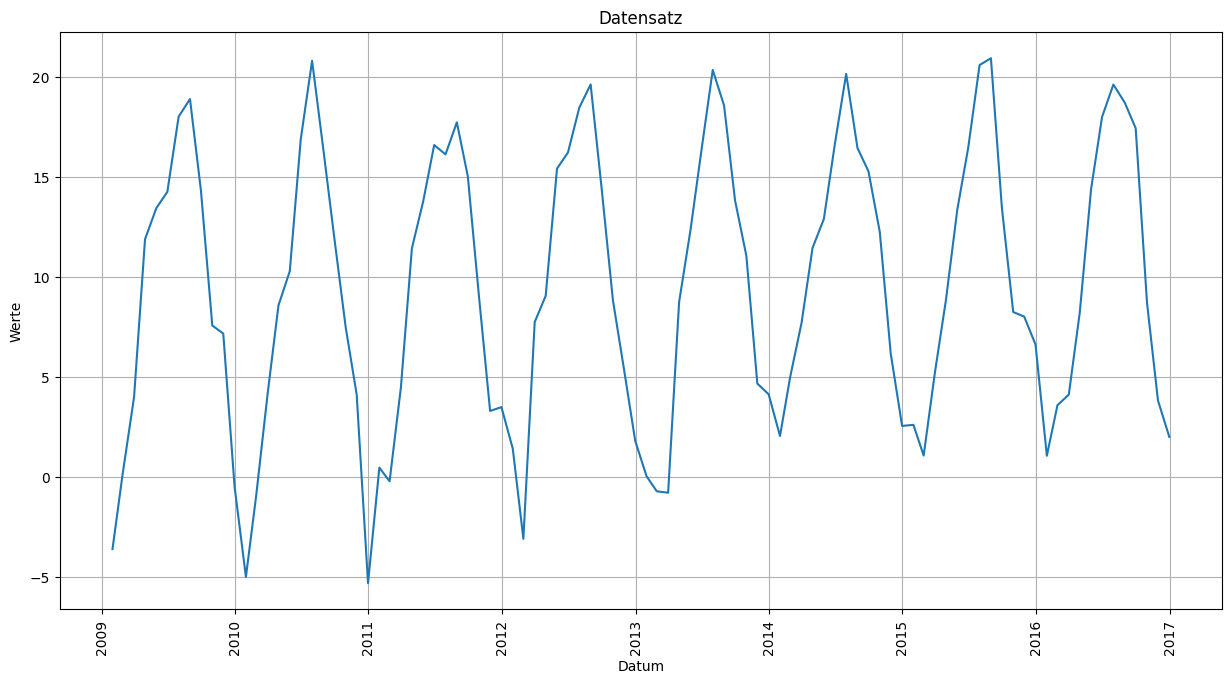

In [5]:
# Datensatz visualisieren und Stationarität bestätigen
plt.figure(figsize=[15, 7.5]); 
date = pd.to_datetime(temp_data["Date_Time"], format="%Y-%m-%d")
plt.plot(date, temp_data[in_str])
plt.title('Datensatz')
plt.ylabel('Werte')
plt.xlabel('Datum')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

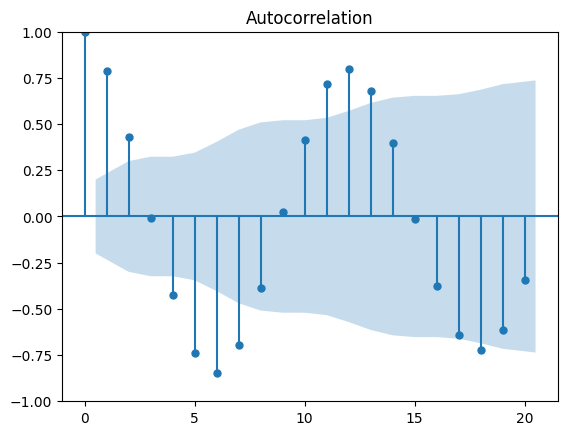

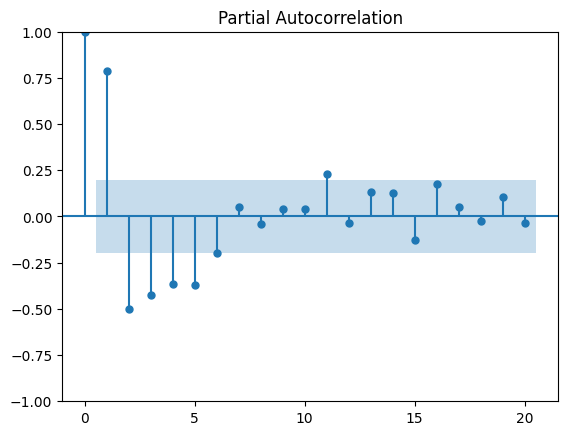

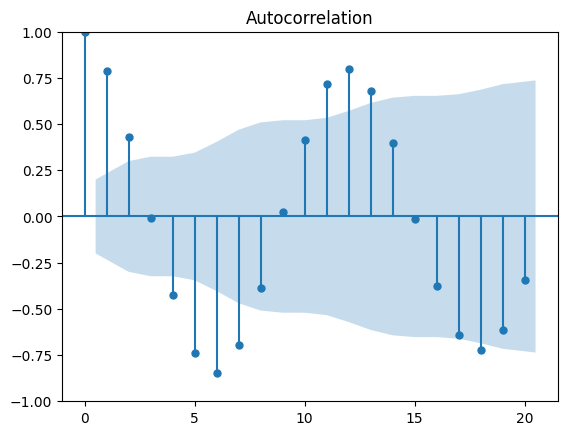

In [6]:
#Das Model benötigt folgende 3 Werte (d,D,s): 
#   - d - Integrationsordnung: Differenzierung bis daten stationär sind.
#   - D - saisonale Integrationsordnung: Differenzierung bis Daten Stationär sind.
#   - s - Länge der Saison: Eine Seasonalität kann sich durch die Periodizität der Welle im Acf bestimmen. 

plot_pacf(temp_data[in_str])
plot_acf(temp_data[in_str])

In [7]:
# Da die PAcf und Acf keine konkreten Daten geben, wird der Dickey-Fuller-test angewendet
# Augmented Dickey-Fuller test: Präsenz von Einheitswurzeln im Datensatz

ad_fuller_result = adfuller(temp_data[in_str])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.3617199450902167
p-value: 0.6004843404349731


In [8]:
#ADF-Statistik: Der Wert von -1.3617199450902167 liegt wahrscheinlich nicht unterhalb des kritischen Werts für einen bestimmten Signifikanzniveau. In der Regel ist ein negativer ADF-Wert ein gutes Zeichen für Stationarität.
#p-Wert: Der p-Wert 0.6004843404349731 bedeutet, dass es sehr wahrscheinlich ist, dass die Zeitreihe eine Einheitswurzel enthält und kann die Nullhypothese nicht abgelehnt werden. => Daten sind nicht Stationär

# Nun müssen Differenzierungen gemacht werden, um die Daten Stationär machen zukönnen und die d - Integrationsordnung und D - saisonale Integrationsordnung zu bekommen.


In [9]:
# Integrationsordnung = d: Erster Differenzierungsschritt
data_d = temp_data.copy()
data_d[in_str] = data_d[in_str].diff(1)
data_d = data_d.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data_d.dropna(subset=[in_str], inplace=True)

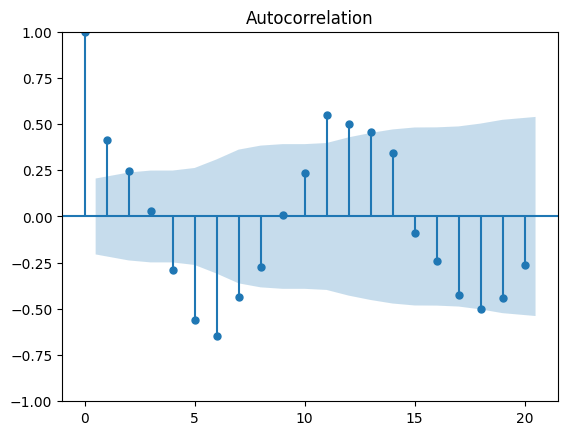

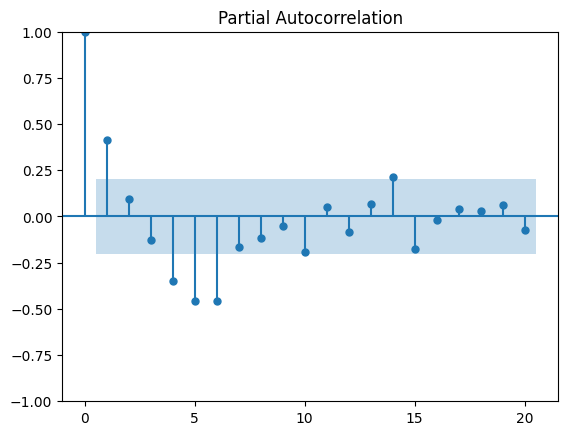

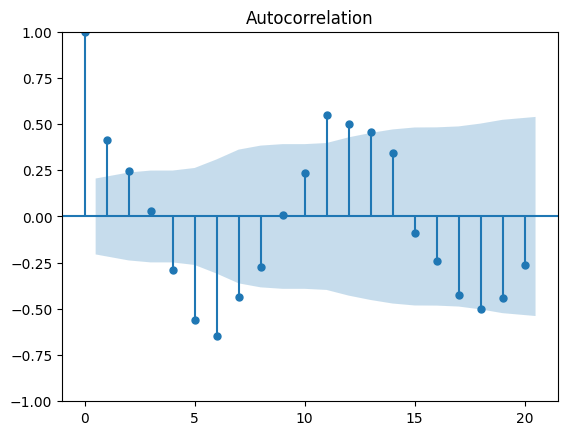

In [10]:
plot_pacf(data_d[in_str])
plot_acf(data_d[in_str])

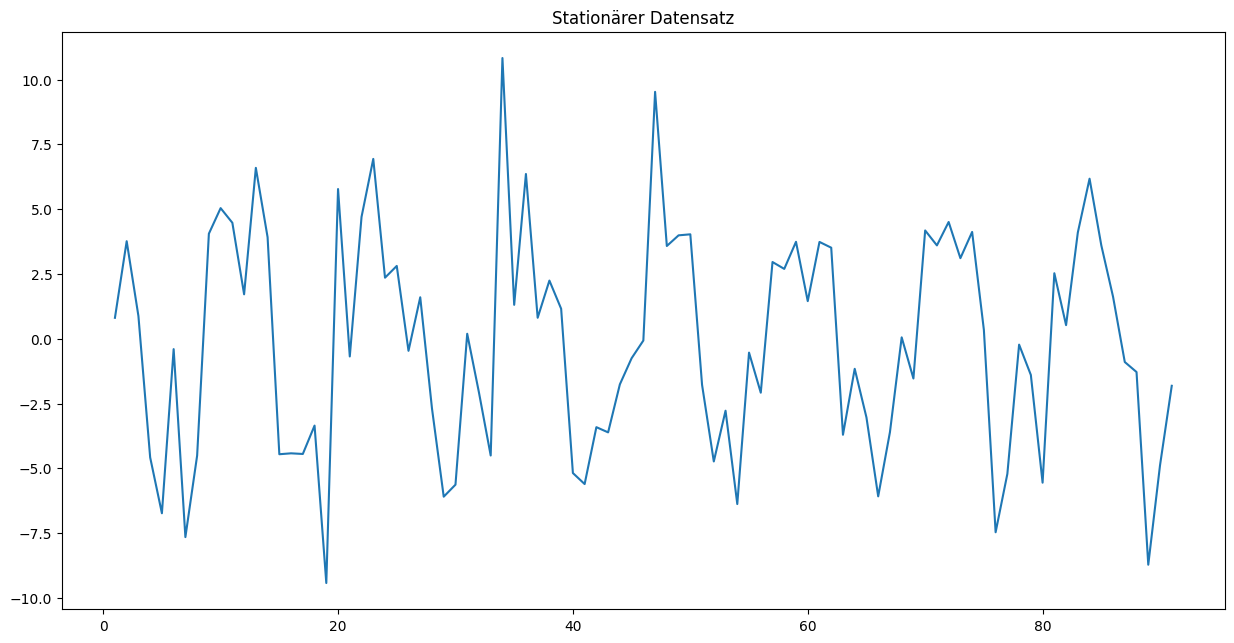

In [11]:
plt.figure(figsize=[15, 7.5]); 
plt.plot(data_d[in_str])
plt.title("Stationärer Datensatz")
plt.show()

In [12]:
ad_fuller_result = adfuller(data_d[in_str])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.008121725501944
p-value: 1.5973031226703908e-07


In [13]:
#Diese Werte deuten darauf hin, dass die Nullhypothese der Nicht-Stationarität nun abgelehnt werden kann, da der p-Wert kleiner ist als das übliche Signifikanzniveau. Die ADF-Statistik ist ausreichend negativ, was zusätzlich darauf hinweist, dass die Zeitreihe jetzt als stationär betrachtet werden kann.
# Somit ist d = 1

# Nun muss noch die saisonalen Integrationsordnung (D) berechnet werden


In [14]:
# Saisonale Integrationsordnung = D: Erster Differenzierungsschritt
data_D = data_d.copy()
data_D[in_str] = data_D[in_str].diff(12)
data_D = data_D.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data_D.dropna(subset=[in_str], inplace=True)

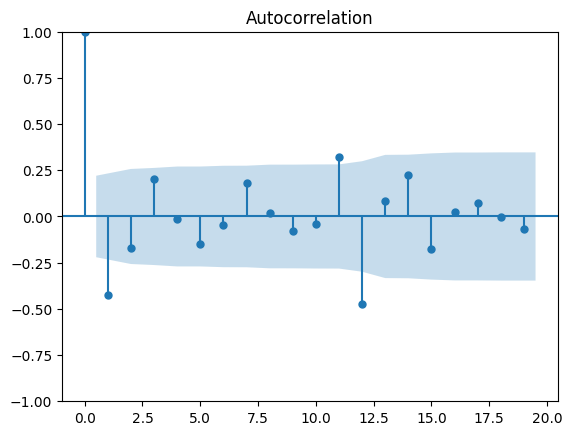

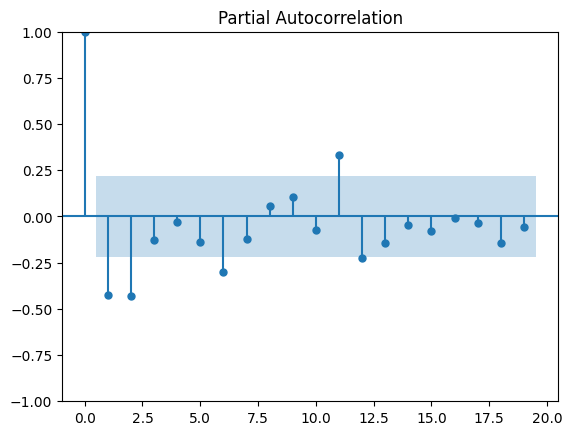

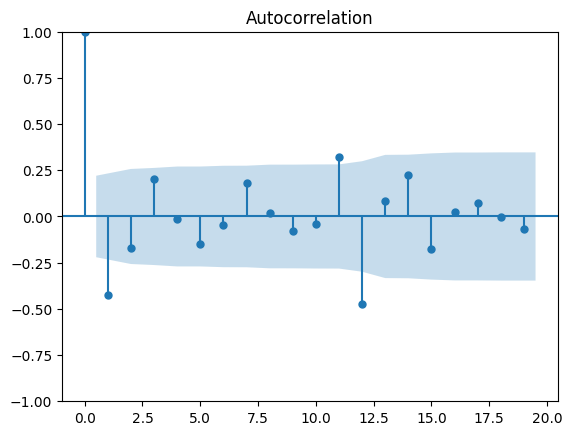

In [15]:
plot_pacf(data_D[in_str])
plot_acf(data_D[in_str])

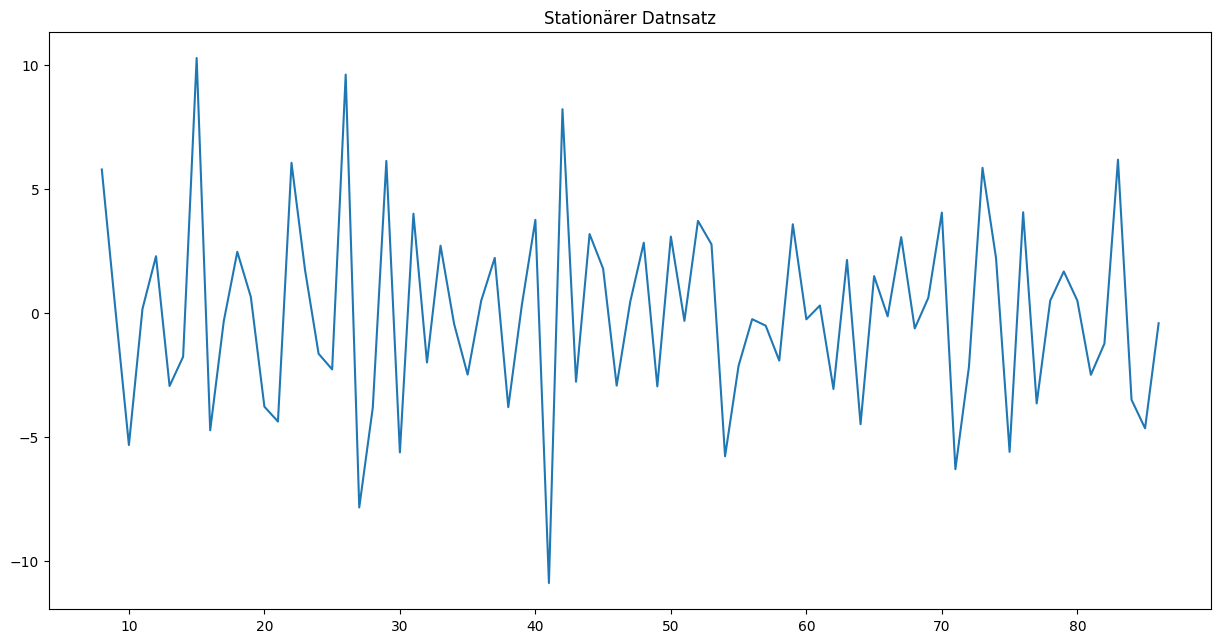

In [16]:
plt.figure(figsize=[15, 7.5]); 
plt.plot(data_D[in_str])
plt.title("Stationärer Datnsatz")
plt.show()

In [17]:
ad_fuller_result = adfuller(data_D[in_str])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.3326283345734837
p-value: 0.013481512260416825


In [18]:
def train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)
    train_data = data[:train_size]
    val_data = data[train_size:train_size+val_size]
    test_data = data[train_size+val_size:]
    return train_data, val_data, test_data


def train_sarimax(train_data, order, seasonal_order):
    return SARIMAX(train_data, order=order, seasonal_order=seasonal_order).fit(dis=-1)

def evaluate_model(model, test_data):
    predictions = model.forecast(steps=len(test_data))
    mae = mean_absolute_error(test_data, predictions)
    return mae

In [19]:
#Das sehr niedrige p-Wert zeigt an, dass die Nullhypothese der Nicht-Stationarität abgelehnt werden kann. Die ADF-Statistik ist ausreichend negativ, was darauf hinweist, dass die Zeitreihe nach der saisonalen Differenzierung bei einer Periode von 12 Monaten stationär ist

# Nun wird der differnenzierte Datensatz für die weiteren Vorgänge verwendet
diff_data = data_D # Nur um die Übersicht zu behalten

In [20]:
train_data, val_data, test_data = train_val_test_split(diff_data)

In [21]:
def optimize_SARIMA(parameters_list, d, D, s, train, exog, exog_future, val_data=None):
    """
        Rückgabe des DataFrame mit Parametern, entsprechenden AIC (relative Qualität statistischer Modelle) und SSE (Differenzen zwischen beobachteten und vorhergesagten Werten).#
        Desto kleiner der AIC und SSE-Wert, desto besser das Model.
        
        
        
        parameters_list - Liste mit Tupeln (p, q, P, Q)
        d - Integrationsordnung
        D - saisonale Integrationsordnung
        s - Länge der Saison
        train - die Trainingsdaten
        exog - die exogene Variable
        exog_future - die exogenen Validierungsdaten
        val_data - die Validierungsdaten
    """
    results = []

    train_df = train.to_frame('train_column_name')
    exog_df = exog.to_frame('exog_column_name')   

    if not train_df.index.equals(exog_df.index):
        # Synchronisierung der Indizes
        combined = train_df.join(exog_df, how='inner')  # Dies führt zu einem DataFrame, bei dem nur übereinstimmende Indizes behalten werden

        # Trennung der synchronisierten Daten zurück in endogen und exogen
        train_synced = combined[train_df.columns]
        exog_synced = combined[exog_df.columns]
    else:
        # Wenn die Indizes bereits übereinstimmen
        train_synced = train_df
        exog_synced = exog_df

    for param in tqdm_notebook(parameters_list):
            
       
        try: 
            model = SARIMAX(endog=train_synced, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), exog=exog_synced).fit(disp=-1)
            aic = model.aic

            # Berechnung des MAE, wenn val_data bereitgestellt wird
            if val_data is not None:
                predictions = model.get_prediction(start=len(train_synced), end=len(train_synced)+len(val_data)-1, exog=exog_future)
                prediction_summary = predictions.summary_frame()
                mae = mean_absolute_error(val_data, prediction_summary['mean'])
                results.append([param, aic, mae])
            else:
                results.append([param, aic])

        except:
            continue
            
    result_df = pd.DataFrame(results)
    print(result_df)
    if val_data is not None:
        result_df.columns = ['(p,q)x(P,Q)', 'AIC', 'MAE']
    else:
        result_df.columns = ['(p,q)x(P,Q)', 'AIC']

    # Sortieren nach AIC (aufsteigend)
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [22]:
# Sowohl die saisonalen als auch die nicht-saisonalen Integrationsparameter sind jeweils 1 , und die Länge der Saison beträgt 12.
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [24]:
result_df = optimize_SARIMA(parameters_list, d, D, s, train_data[in_str],train_data[exog_str], val_data[exog_str], val_data[in_str])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

                0           1         2
0    (0, 0, 0, 0)  338.178118  7.487650
1    (0, 0, 0, 1)  316.132129  6.047789
2    (0, 0, 0, 2)  311.809019  6.808745
3    (0, 0, 0, 3)  313.847583  6.827299
4    (0, 0, 1, 0)  313.403779  5.394674
..            ...         ...       ...
251  (3, 3, 2, 3)  267.061400  3.751665
252  (3, 3, 3, 0)  263.257203  3.471636
253  (3, 3, 3, 1)  265.207384  3.834380
254  (3, 3, 3, 2)  267.009222  3.456664
255  (3, 3, 3, 3)  268.890113  3.485709

[256 rows x 3 columns]


,"(p,q)x(P,Q)",AIC,MAE
0,"(0, 2, 3, 0)",256.156021,2.925397
1,"(1, 2, 3, 0)",257.562713,2.888063
2,"(0, 2, 0, 2)",257.577758,2.508686
3,"(0, 3, 3, 0)",257.710074,2.885830
4,"(0, 2, 3, 1)",258.188474,2.994954
...,...,...,...
251,"(0, 0, 0, 1)",316.132129,6.047789
252,"(0, 0, 3, 3)",317.384713,5.568609
253,"(0, 0, 2, 3)",317.757993,7.219364
254,"(1, 0, 0, 0)",319.394002,4.845480


In [25]:
result_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

,"(p,q)x(P,Q)",AIC,MAE
0,"(3, 0, 2, 2)",274.443499,2.222928
1,"(3, 1, 2, 1)",263.941018,2.241411
2,"(3, 1, 2, 2)",265.381600,2.262930
3,"(3, 1, 2, 3)",267.212208,2.276430
4,"(2, 2, 2, 2)",265.714527,2.286412
...,...,...,...
251,"(0, 0, 0, 3)",313.847583,6.827299
252,"(0, 0, 1, 3)",315.842179,6.877184
253,"(0, 0, 2, 2)",315.844113,6.968611
254,"(0, 0, 2, 3)",317.757993,7.219364


In [33]:
# Best model ist ARIMA 0,2,3,0) AIC=256
# Das SARIMAX ist eine erweiterung des SARIMA's. Diese lässt zusätzliche Variablen von außen zu. zB könnte diese die Tageszeiten beinhalten, welche Einfluss auf die Wetterbedingungen haben könnte.
# order=(p,d,q) => p=0, d=1, q=2
# seasonal_order=(P,D,Q,s) => P=3, D=1, Q=0, s=12
best_model = SARIMAX(diff_data[in_str], exog=diff_data[exog_str], order=(3, 1, 0), seasonal_order=(2,1,2,12)).fit(dis=-1)
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                T_(degC)   No. Observations:                   79
Model:             SARIMAX(3, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood                -186.671
Date:                                 Mon, 19 Feb 2024   AIC                            391.342
Time:                                         15:21:42   BIC                            411.049
Sample:                                              0   HQIC                           399.129
                                                  - 79                                         
Covariance Type:                                   opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
day_of_month    45.7715     66.537      0.688      0.492     -84.638  

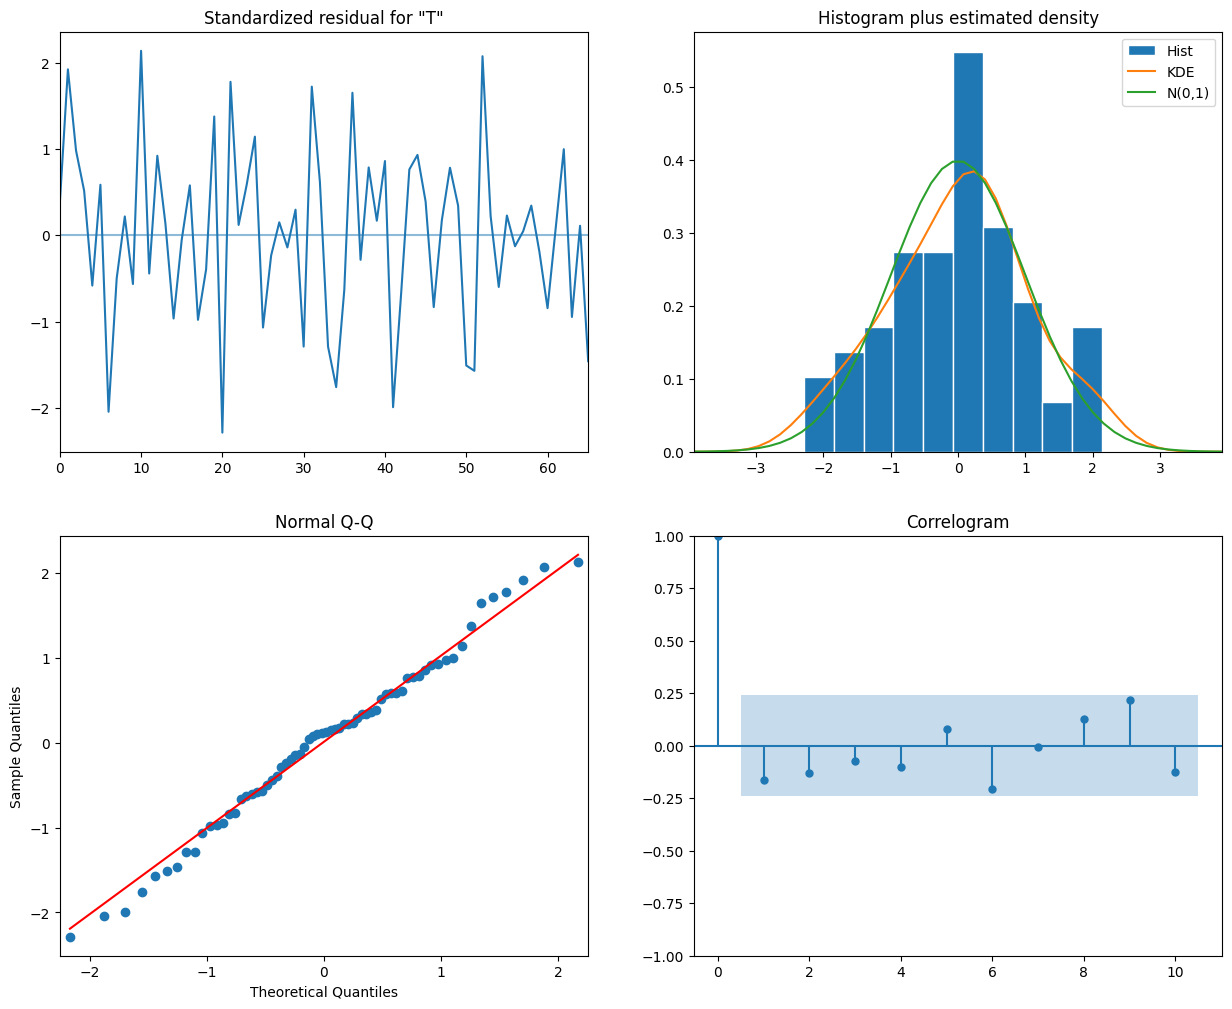

In [34]:
best_model.plot_diagnostics(figsize=(15,12));

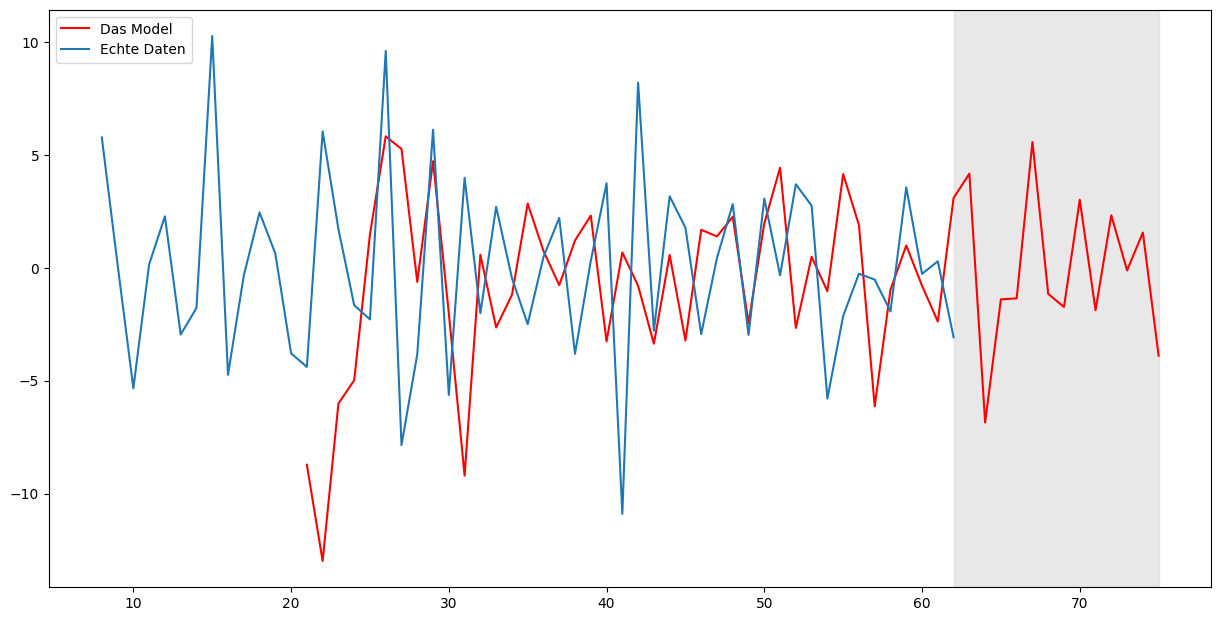

In [35]:
plot_data = train_data

plot_data['arima_model'] = best_model.fittedvalues
plot_data['arima_model'][:12+1] = np.NaN

forecast = best_model.predict(start=plot_data.shape[0], end=plot_data.shape[0] + 12)
forecast = plot_data['arima_model']._append(forecast) # Notizen für mich_append benuten und nicht append (neue Version von Pandas)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast[-150:], color='r', label='Das Model')
plt.axvspan(plot_data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(plot_data[in_str][-150:], label='Echte Daten')
plt.legend()

plt.show()

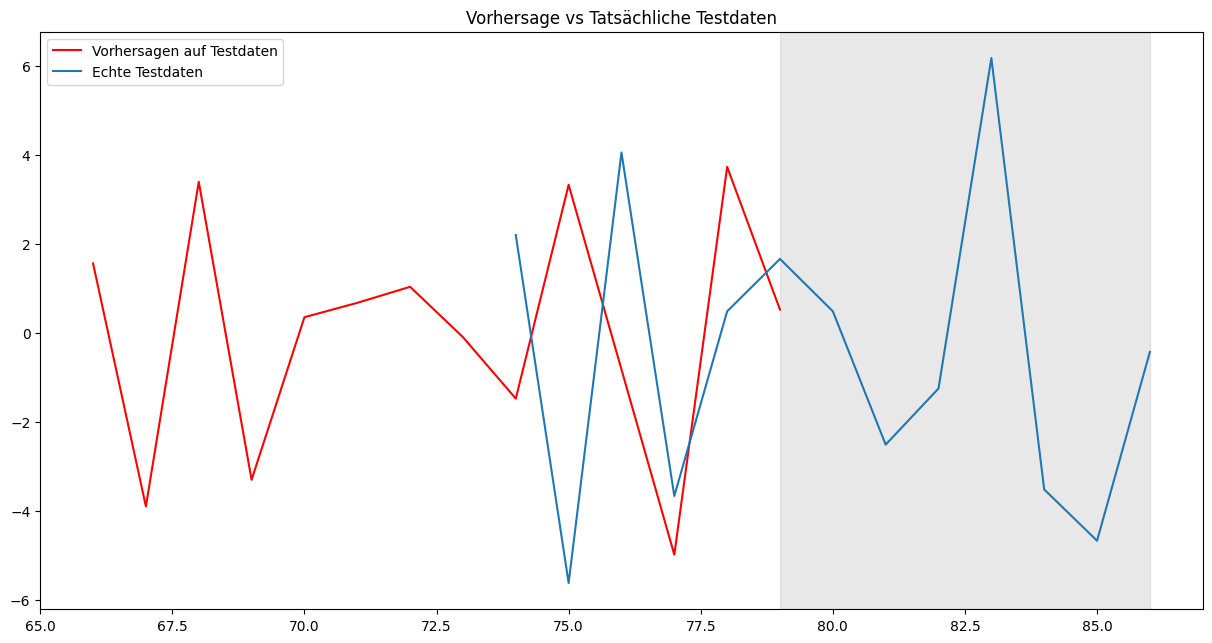

In [36]:
# TEST_DATA

test_forecast = best_model.predict(start=train_data.shape[0]+val_data.shape[0], end=train_data.shape[0]+val_data.shape[0] + test_data.shape[0], exog=test_data[exog_str][-2:-1])

# Visualisierung der Vorhersagen für die Testdaten
plt.figure(figsize=(15, 7.5))
plt.plot(test_forecast[-150:], color='r', label='Vorhersagen auf Testdaten')
plt.axvspan(test_data.index[-1], test_forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(test_data[in_str][-150:], label='Echte Testdaten')

plt.legend()
plt.title('Vorhersage vs Tatsächliche Testdaten')
plt.show() 

In [37]:
from sklearn.metrics import mean_absolute_error

# Berechnung des MAE
mae = mean_absolute_error(test_data[in_str], test_forecast[:-1])
mae

1.3619208782485943

In [38]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_data[in_str], test_forecast[:-1])
mse

3.3732258473247896

In [39]:
def smape_loss(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()
smape = smape_loss(test_data[in_str], test_forecast[:-1])
smape

1.567560506729445